In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install grad-cam -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

# FERPLUS dataset path
FERPLUS_PATH = "/content/drive/MyDrive/DEEP LEARNING/archive (1)"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'suprise']

Using cuda


In [ ]:
class EmotionCNN(nn.Module):
    """VGG-style CNN for FERPLUS emotion recognition"""
    def __init__(self, num_classes=6):
        super(EmotionCNN, self).__init__()

        self.conv1 = self._make_block(3, 64)
        self.conv2 = self._make_block(64, 128)
        self.conv3 = self._make_block(128, 256)
        self.conv4 = self._make_block(256, 512)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def _make_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = EmotionCNN(num_classes=len(EMOTIONS)).to(device)
print('Model ready')

Model ready


In [ ]:
train_tf = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_tf = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
def filter_emotions(dataset, emotions):
    idx_map = {c: i for i, c in enumerate(emotions)}
    filtered = [(p, idx_map[dataset.classes[l]])
                for p, l in dataset.samples
                if dataset.classes[l] in emotions]
    dataset.samples = filtered
    dataset.targets = [s[1] for s in filtered]
    dataset.classes = emotions
    return dataset

# Load FERPLUS dataset
train_ds = datasets.ImageFolder(f'{FERPLUS_PATH}/train', train_tf)
test_ds = datasets.ImageFolder(f'{FERPLUS_PATH}/test', test_tf)
train_ds = filter_emotions(train_ds, EMOTIONS)
test_ds = filter_emotions(test_ds, EMOTIONS)

print(f'FERPLUS Train: {len(train_ds)}, Test: {len(test_ds)}')

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, 64, shuffle=False, num_workers=2)

FERPLUS Train: 48000, Test: 2269


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)

            total_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [ ]:
NUM_EPOCHS = 30
best_acc = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'  Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%')
    print(f'  Test:  loss={test_loss:.4f}, acc={test_acc*100:.2f}%')

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/ferplus_model.pth')
        print(f'  -> saved ({best_acc*100:.2f}%)')

print(f'\nDone! Best accuracy: {best_acc*100:.2f}%')

Epoch 1/30
  Train: loss=1.4163, acc=40.36%
  Test:  loss=1.1052, acc=57.16%
  -> saved (57.16%)
Epoch 2/30
  Train: loss=0.8844, acc=66.96%
  Test:  loss=0.7903, acc=72.28%
  -> saved (72.28%)
Epoch 3/30
  Train: loss=0.6346, acc=77.26%
  Test:  loss=0.6598, acc=77.74%
  -> saved (77.74%)
Epoch 4/30
  Train: loss=0.5024, acc=82.41%
  Test:  loss=0.5950, acc=81.09%
  -> saved (81.09%)
Epoch 5/30
  Train: loss=0.4186, acc=85.38%
  Test:  loss=0.7566, acc=78.89%
Epoch 6/30
  Train: loss=0.3589, acc=87.73%
  Test:  loss=0.8201, acc=77.66%
Epoch 7/30
  Train: loss=0.3160, acc=89.38%
  Test:  loss=0.6469, acc=82.02%
  -> saved (82.02%)
Epoch 8/30
  Train: loss=0.2791, acc=90.49%
  Test:  loss=0.6157, acc=82.50%
  -> saved (82.50%)
Epoch 9/30
  Train: loss=0.1960, acc=93.50%
  Test:  loss=0.6916, acc=82.55%
  -> saved (82.55%)
Epoch 10/30
  Train: loss=0.1729, acc=94.37%
  Test:  loss=0.6855, acc=82.19%
Epoch 11/30
  Train: loss=0.1580, acc=94.76%
  Test:  loss=0.6596, acc=84.57%
  -> saved 

In [ ]:
# Load previous FERPLUS model and continue training
model.load_state_dict(torch.load('/content/drive/MyDrive/ferplus_model.pth'))

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

NUM_EPOCHS = 20
best_acc = 0.8572

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'  Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%')
    print(f'  Test:  loss={test_loss:.4f}, acc={test_acc*100:.2f}%')

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/ferplus_model.pth')
        print(f'  -> saved ({best_acc*100:.2f}%)')

print(f'\nDone! Best accuracy: {best_acc*100:.2f}%')

Epoch 1/20
  Train: loss=0.0456, acc=98.46%
  Test:  loss=0.9811, acc=85.50%
Epoch 2/20
  Train: loss=0.0473, acc=98.44%
  Test:  loss=0.9729, acc=85.02%
Epoch 3/20
  Train: loss=0.0460, acc=98.46%
  Test:  loss=0.9650, acc=84.97%
Epoch 4/20
  Train: loss=0.0457, acc=98.43%
  Test:  loss=0.9695, acc=85.46%
Epoch 5/20
  Train: loss=0.0429, acc=98.54%
  Test:  loss=1.0066, acc=85.15%
Epoch 6/20
  Train: loss=0.0440, acc=98.56%
  Test:  loss=0.9670, acc=85.28%
Epoch 7/20
  Train: loss=0.0412, acc=98.65%
  Test:  loss=0.9911, acc=85.37%
Epoch 8/20
  Train: loss=0.0376, acc=98.73%
  Test:  loss=1.0219, acc=85.68%
Epoch 9/20
  Train: loss=0.0355, acc=98.83%
  Test:  loss=1.0597, acc=85.41%
Epoch 10/20
  Train: loss=0.0351, acc=98.78%
  Test:  loss=1.0525, acc=85.10%
Epoch 11/20
  Train: loss=0.0347, acc=98.81%
  Test:  loss=1.0249, acc=85.41%
Epoch 12/20
  Train: loss=0.0331, acc=98.86%
  Test:  loss=1.0771, acc=85.50%
Epoch 13/20
  Train: loss=0.0317, acc=98.92%
  Test:  loss=1.0751, acc=85

In [39]:
# Test loading model
model = EmotionCNN(num_classes=6).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ferplus_model.pth'))
model.eval()

from PIL import Image
import os

test_img_path = f'{FERPLUS_PATH}/test/happy'
test_img = os.listdir(test_img_path)[0]
img = Image.open(f'{test_img_path}/{test_img}')

img_tensor = test_tf(img).unsqueeze(0).to(device)

with torch.no_grad():
    out = model(img_tensor)
    pred = out.argmax(1).item()

print(f'Prediction: {EMOTIONS[pred]}')
print(f'Ground truth: happy')

Prediction: happy
Ground truth: happy


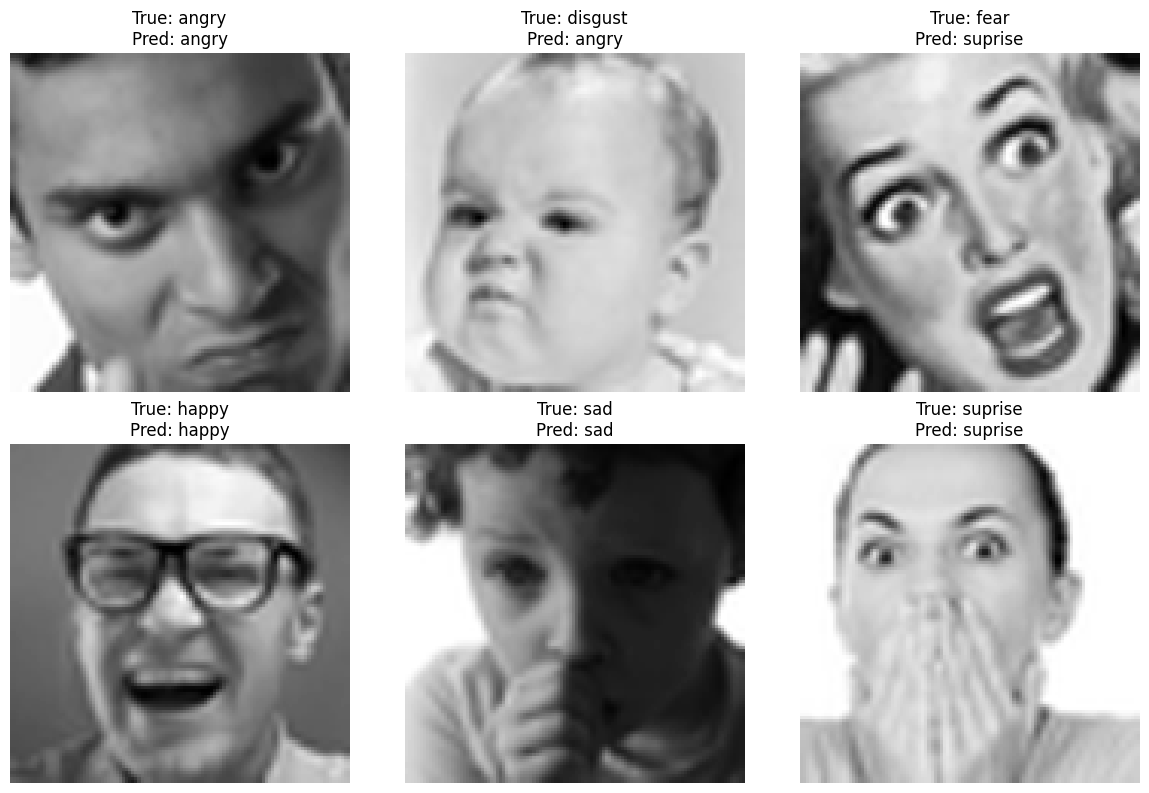

In [42]:
# Test multiple images from test set
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, emotion in enumerate(EMOTIONS):
    test_path = f'{FERPLUS_PATH}/test/{emotion}'
    imgs = os.listdir(test_path)
    random_img = random.choice(imgs)

    img = Image.open(f'{test_path}/{random_img}')
    img_tensor = test_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_tensor)
        pred = out.argmax(1).item()

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {emotion}\nPred: {EMOTIONS[pred]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()